In [1]:
# check against table 7

In [13]:
import cantera as ct
import numpy as np
import pandas as pd
import concurrent.futures


import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# # Load the model

cti_path = '/home/moon/autoscience/autoscience/paper/error_vs_num_included/change3.cti'
cti_path = '/home/moon/autoscience/autoscience/paper/error_vs_num_included/change4.cti'

cti_path = '/home/moon/autoscience/autoscience/paper/error_vs_num_included/mechs/top_50.cti'

gas = ct.Solution(cti_path)

In [15]:
# Load the experimental conditions
ignition_delay_data = '/work/westgroup/harris.se/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
ignition_delay_data = '/home/moon/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == 7]
# Define Initial conditions using experimental data
tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
T7 = table7['T_C'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm


# list of starting conditions
# Mixture compositions taken from table 2 of
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
concentrations = []
# for phi = 1
x_diluent = 0.7649
conc_dict = {
    'O2(2)': 0.2038,
    'butane(1)': 0.03135
}

for i in range(0, len(table7)):
    x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
    x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
    x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
    conc_dict['N2'] = x_N2
    conc_dict['Ar'] = x_Ar
    conc_dict['CO2(7)'] = x_CO2
    concentrations.append(conc_dict)

    
# # Aramco naming:
# x_diluent = 0.7649
# conc_dict = {
#     'O2': 0.2038,
#     'C4H10': 0.03135
# }

# for i in range(0, len(table7)):
#     x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
#     x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
#     x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
#     conc_dict['N2'] = x_N2
#     conc_dict['AR'] = x_Ar
#     conc_dict['CO2'] = x_CO2
#     concentrations.append(conc_dict)


In [16]:
# Take Reactor Conditions from Table 7 of supplementary info in
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
def get_delay(gas, T, P, X):
    # function to run a RCM simulation

    t_end = 1.0  # time in seconds
    gas.TPX = T, P, X

    env = ct.Reservoir(ct.Solution('air.yaml'))
    # env = ct.Reservoir(ct.Solution('air.xml'))
    reactor = ct.IdealGasReactor(gas)
    wall = ct.Wall(reactor, env, A=1.0, velocity=0)
    reactor_net = ct.ReactorNet([reactor])
    # # allegedly faster solving
    # reactor_net.derivative_settings = {"skip-third-bodies": True, "skip-falloff": True}
    # reactor_net.preconditioner = ct.AdaptivePreconditioner()

    times = [0]
    T = [reactor.T]
    P = [reactor.thermo.P]
    X = [reactor.thermo.X]  # mol fractions
    while reactor_net.time < t_end:
        reactor_net.step()

        times.append(reactor_net.time)
        T.append(reactor.T)
        P.append(reactor.thermo.P)
        X.append(reactor.thermo.X)

    slopes = np.gradient(P, times)
    i = np.argmax(slopes)
    return times[i]

In [17]:
def run_simulation(condition_index):
    gas = ct.Solution(cti_path)
    X = concentrations[condition_index]
    delay = get_delay(gas, T7[condition_index], P7[condition_index], X)
    print(f'Completed {condition_index}:\t {delay}')
    return delay

In [18]:
# Run all simulations in parallel
delays = np.zeros(len(table7))
condition_indices = np.arange(0, len(table7))
with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
    for condition_index, delay_time in zip(condition_indices, executor.map(run_simulation, condition_indices)):
        delays[condition_index] = delay_time

Completed 13:	 0.023056581172137203
Completed 12:	 0.03232850670612388
Completed 11:	 0.04832536247053643
Completed 8:	 0.07773079397739042
Completed 15:	 0.013349980117965045
Completed 10:	 0.05510943850230538
Completed 14:	 0.021915103574382273
Completed 6:	 0.06233078793116345Completed 7:	 0.06325819694043666

Completed 9:	 0.07245250627918526
Completed 5:	 0.038312926811012345
Completed 4:	 0.03802088337196897
Completed 3:	 0.036390418853613486
Completed 1:	 0.05074970042020011
Completed 2:	 0.036543565962512646
Completed 0:	 0.05161143653921929


In [19]:
delays

array([0.05161144, 0.0507497 , 0.03654357, 0.03639042, 0.03802088,
       0.03831293, 0.06233079, 0.0632582 , 0.07773079, 0.07245251,
       0.05510944, 0.04832536, 0.03232851, 0.02305658, 0.0219151 ,
       0.01334998])

In [22]:
# Saved ignition delays for comparison:

top50 = np.array([0.05161144, 0.0507497 , 0.03654357, 0.03639042, 0.03802088,
       0.03831293, 0.06233079, 0.0632582 , 0.07773079, 0.07245251,
       0.05510944, 0.04832536, 0.03232851, 0.02305658, 0.0219151 ,
       0.01334998])

ultra4 = np.array([0.04065677, 0.03994381, 0.02927439, 0.02921865, 0.03305727,
       0.03343595, 0.05951802, 0.06046236, 0.07695574, 0.07194765,
       0.05499949, 0.0483019 , 0.03244368, 0.0232204 , 0.02208335,
       0.01353823])

base_rmg7 = np.array([0.04908328, 0.04854439, 0.04814446, 0.04868176, 0.075588  ,
       0.07737167, 0.14791668, 0.14857535, 0.1085917 , 0.0952434 ,
       0.06520823, 0.05563237, 0.03535775, 0.02462961, 0.02334903,
       0.01398333])  # 24 hour RMG run - 110 species

aramco7 = np.array([0.03945921, 0.03874611, 0.02817182, 0.02812066, 0.03236667,
       0.03278732, 0.06009581, 0.06085926, 0.06020536, 0.05459522,
       0.03965133, 0.03435827, 0.02245863, 0.01580939, 0.01499945,
       0.00896072])
experiment7 = np.array([0.0865 , 0.0739 , 0.0313 , 0.033  , 0.0309 , 0.03   , 0.056  ,
       0.0566 , 0.0679 , 0.0664 , 0.0652 , 0.0671 , 0.047  , 0.0279 ,
       0.02805, 0.012  ])


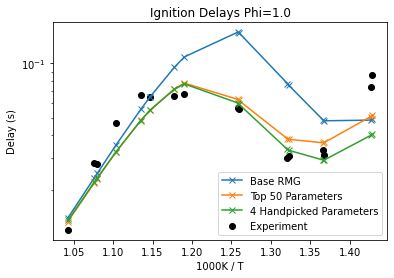

In [35]:
# plot the ignition delay
plt.plot(1000.0 / T7, base_rmg7, marker='x')
plt.plot(1000.0 / T7, top50, marker='x')
plt.plot(1000.0 / T7, ultra4, marker='x')
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black')
ax = plt.gca()
ax.set_yscale('log')
plt.legend(['Base RMG', 'Top 50 Parameters', '4 Handpicked Parameters', 'Experiment'])
plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table7.png')
# plt.legend(bbox_to_anchor=(0, 1), , ncol=1)

In [14]:
tau7

array([86.5 , 73.9 , 31.3 , 33.  , 30.9 , 30.  , 56.  , 56.6 , 67.9 ,
       66.4 , 65.2 , 67.1 , 47.  , 27.9 , 28.05, 12.  ])

## Calculate Simple Linear Squared Error

In [26]:
def get_error(points):
    return np.dot(points - experiment7, points - experiment7)

In [34]:
print('Errors:')
print('  Base RMG\t', get_error(base_rmg7))
print('  Top 50\t', get_error(top50))
print('  4 Handpicked\t', get_error(ultra4))
print('  Aramco\t', get_error(aramco7))

Errors:
  Base RMG	 0.026513337786497698
  Top 50	 0.002862114847202599
  4 Handpicked	 0.004158734122786998
  Aramco	 0.006378394111488899
